pip install libtiff

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

## view datasets

In [ ]:
from libtiff import TIFF
import matplotlib.pyplot as plt
from skimage.transform import match_histograms

import numpy as np
def normalize(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

root = '/home/yons/data/change-detection/rssrai2019_change_detection/train/train'
import glob
from libtiff import TIFF
from skimage.transform import match_histograms

image_path_list_2018 = glob.glob(root+'/img_2018'+'/*.tif')
image_path_list_2018.sort()
image_path_list_2017 = glob.glob(root+'/img_2017'+'/*.tif')
image_path_list_2017.sort()
image_path_list_mask = glob.glob(root+'/mask'+'/*.tif')
image_path_list_mask.sort()

for idx in range(18):
    
    image1 = TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:, :, [2, 1, 0]]
    image2 = TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:, :, [2, 1, 0]]
    image2 = match_histograms(image2, image1, multichannel=True)
    label = TIFF.open(image_path_list_mask[idx], mode='r').read_image()
    label = (label / 255).astype(np.uint8)
    
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0)
    axes[0].imshow(normalize(image1))
    axes[0].axis('off')
    axes[1].imshow(normalize(image2))
    axes[1].axis('off')
    axes[2].imshow(label)
    axes[2].axis('off')
    
    
    
plt.show()


## define net

In [4]:
import torch
from torch import nn


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = nn.functional.interpolate(x1, scale_factor=2)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), double_conv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), double_conv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), double_conv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), double_conv(512, 512))

        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
from torchsummary import summary
net = UNet(6,2)
summary(net, input_size=[(3, 960, 960), (3, 960, 960)], batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 960, 960]           3,520
       BatchNorm2d-2          [1, 64, 960, 960]             128
              ReLU-3          [1, 64, 960, 960]               0
            Conv2d-4          [1, 64, 960, 960]          36,928
       BatchNorm2d-5          [1, 64, 960, 960]             128
              ReLU-6          [1, 64, 960, 960]               0
       double_conv-7          [1, 64, 960, 960]               0
         MaxPool2d-8          [1, 64, 480, 480]               0
            Conv2d-9         [1, 128, 480, 480]          73,856
      BatchNorm2d-10         [1, 128, 480, 480]             256
             ReLU-11         [1, 128, 480, 480]               0
           Conv2d-12         [1, 128, 480, 480]         147,584
      BatchNorm2d-13         [1, 128, 480, 480]             256
             ReLU-14         [1, 128, 4

## define loader

In [6]:
import itertools
import glob
from libtiff import TIFF
import numpy as np
from torch.utils.data import Dataset

from skimage.transform import match_histograms
import torch
class SctDataset(Dataset):
    def __init__(self, root, size=512, slide=256):
        image_path_list_2018 = glob.glob(root + '/img_2018' + '/*.tif')
        image_path_list_2018.sort()
        image_path_list_2017 = glob.glob(root + '/img_2017' + '/*.tif')
        image_path_list_2017.sort()
        image_path_list_mask = glob.glob(root + '/mask' + '/*.tif')
        image_path_list_mask.sort()
        self.image_path_list_2018 = image_path_list_2018
        self.image_path_list_2017 = image_path_list_2017
        self.image_path_list_mask = image_path_list_mask

    def __getitem__(self, idx):

        image1 = TIFF.open(self.image_path_list_2017[idx], mode='r').read_image()[:, :, [2, 1, 0]].transpose((2, 0, 1))
        image2 = TIFF.open(self.image_path_list_2018[idx], mode='r').read_image()[:, :, [2, 1, 0]].transpose((2, 0, 1))
        image2 = match_histograms(image2, image1, multichannel=True)
        label = TIFF.open(self.image_path_list_mask[idx], mode='r').read_image()
        label = (label / 255).astype(np.uint8)

        return torch.from_numpy(image1.astype(np.float32)), torch.from_numpy(image2.astype(np.float32)), torch.from_numpy(label).long()

    def __len__(self):
        return len(self.image_path_list_2018)
from torch.utils.data import DataLoader
test_loader = DataLoader(SctDataset('/home/yons/data/change-detection/rssrai2019_change_detection/train/train'), batch_size=1, shuffle=True, num_workers=1)
test_iter = iter(test_loader)
x1, x2, target = next(test_iter)
print(x1.shape,x2.shape,target.shape)

torch.Size([1, 3, 960, 960]) torch.Size([1, 3, 960, 960]) torch.Size([1, 960, 960])


## define criterion

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-7, size_average=True):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.size_average = size_average
        self.eps = eps

    def forward(self, logits, true):
        """Computes the Tversky loss [1].
        Args:
            true: a tensor of shape [B, H, W] or [B, 1, H, W].
            logits: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model.
            alpha: controls the penalty for false positives.
            beta: controls the penalty for false negatives.
            eps: added to the denominator for numerical stability.
        Returns:
            tversky_loss: the Tversky loss.
        Notes:
            alpha = beta = 0.5 => dice coeff
            alpha = beta = 1 => tanimoto coeff
            alpha + beta = 1 => F beta coeff
        References:
            [1]: https://arxiv.org/abs/1706.05721
        """
        num_classes = logits.shape[1]
        if num_classes == 1:
            true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            true_1_hot_f = true_1_hot[:, 0:1, :, :]
            true_1_hot_s = true_1_hot[:, 1:2, :, :]
            true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
            pos_prob = torch.sigmoid(logits)
            neg_prob = 1 - pos_prob
            probas = torch.cat([pos_prob, neg_prob], dim=1)
        else:
            true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            probas = F.softmax(logits, dim=1)

        true_1_hot = true_1_hot.type(logits.type())
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        fps = torch.sum(probas * (1 - true_1_hot), dims)
        fns = torch.sum((1 - probas) * true_1_hot, dims)
        num = intersection
        denom = intersection + (self.alpha * fps) + (self.beta * fns)
        tversky_loss = (num / (denom + self.eps)).mean()
        return (1 - tversky_loss)
criterion = TverskyLoss(alpha=0.3, beta=0.7)
y = net(x1,x2)
loss = criterion(y, target)
print(loss.item())

0.6770436763763428


in my experiment, the classical cross entropy loss is shockly bad. And the parameter of the TverskyLoss is needed to be trend carefully. 0.3 and 0.7 is the best in my experiment.

## train

In [ ]:
from tqdm import tqdm_notebook as tqdm
import torch
train_loader = DataLoader(SctDataset('/home/yons/data/change-detection/rssrai2019_change_detection/train/train'), batch_size=1, shuffle=True, num_workers=1)
val_loader = DataLoader(SctDataset('/home/yons/data/change-detection/rssrai2019_change_detection/val/val'), batch_size=1, shuffle=True, num_workers=1)
print('train: ', len(train_loader))
print('val: ', len(val_loader))

best_loss = 9999

save_dir = '/home/yons/workplace/python/change-detection/log/0.4'
import shutil, os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    shutil.rmtree(save_dir)
    os.makedirs(save_dir)
        
net = UNet(6, 2)
net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 8, 15], gamma=0.1)

for epoch in range(20):
    net.train()
    train_loss = 0
    for step, data in tqdm(enumerate(train_loader)):
        x1, x2, target = data
        x1, x2, target = x1.cuda(), x2.cuda(), target.cuda()
        optimizer.zero_grad()
        y = net(x1, x2)
        loss = criterion(y, target)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    train_loss = train_loss / len(train_loader)
    net.eval()
    with torch.no_grad():
        val_loss = 0
        for step, data in tqdm(enumerate(val_loader)):
            x1, x2, target = data
            x1, x2, target = x1.cuda(), x2.cuda(), target.cuda()
            y = net(x1, x2)
            loss = criterion(y, target)
            val_loss = val_loss + loss.item()
        val_loss = val_loss / len(val_loader)
    print(epoch, train_loss, val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        save_path = os.path.join(save_dir, 'best_loss.pth')
        state = {
            'net': net.state_dict(),
            'epoch': epoch,
            'loss': best_loss
        }
        torch.save(state, save_path)
    scheduler.step()

## evaluate

In [11]:
net = UNet(6, 2)
net = net.cuda()
checkpoint = torch.load('/home/yons/workplace/python/change-detection/log/0.4/best_loss.pth')
net.load_state_dict(checkpoint['net'])
print(checkpoint['loss'], checkpoint['epoch'])

0.39102962613105774 19


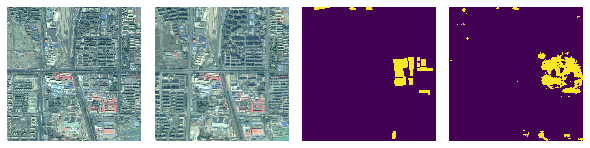

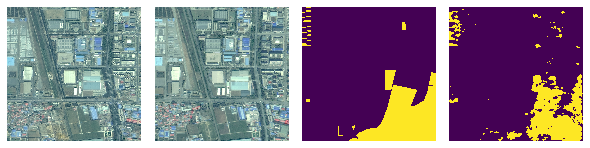


0.39102962613105774


In [21]:
def normalize(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
net.eval()
with torch.no_grad():
    val_loss = 0
    for step, data in tqdm(enumerate(val_loader)):
        x1, x2, target = data
        x1, x2, target = x1.cuda(), x2.cuda(), target.cuda()
        y = net(x1, x2)
        loss = criterion(y, target)
        val_loss = val_loss + loss.item()
        
        x1 = x1.cpu().numpy()[0].transpose((1,2,0))
        x2 = x2.cpu().numpy()[0].transpose((1,2,0))
        _, y = torch.max(y, 1)
        y = y.cpu().numpy()[0]
        target = target.cpu().numpy()[0]
        
        fig, axes = plt.subplots(1,4, figsize=(8,2))
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)
        
        image1 = TIFF.open(image_path_list_2017[step], mode='r').read_image()[:,:,[2,1,0]]
        image2 = TIFF.open(image_path_list_2018[step], mode='r').read_image()[:,:,[2,1,0]]
        image2 = match_histograms(image2, image1, multichannel=True)
        axes[0].imshow(normalize(image1))
        axes[0].axis('off')
        axes[1].imshow(normalize(image2))
        axes[1].axis('off')
        axes[2].imshow(target)
        axes[2].axis('off')
        axes[3].imshow(y)
        axes[3].axis('off')
        
        plt.show()
    val_loss = val_loss / len(val_loader)
print(val_loss)

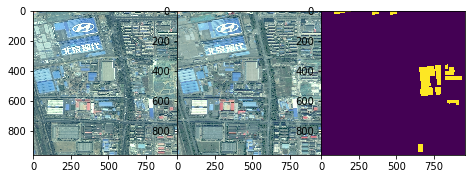

In [12]:
root = '/home/yons/data/rssrai2019_change_detection/val/val'
import glob
from libtiff import TIFF
from skimage.transform import match_histograms

image_path_list_2018 = glob.glob(root+'/img_2018'+'/*.tif')
image_path_list_2018.sort()
image_path_list_2017 = glob.glob(root+'/img_2017'+'/*.tif')
image_path_list_2017.sort()
image_path_list_mask = glob.glob(root+'/mask'+'/*.tif')
image_path_list_mask.sort()

idx = 0
image1 = TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:,:,[2,1,0]]
image2 = TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:,:,[2,1,0]]
image2 = match_histograms(image2, image1, multichannel=True)
mask = TIFF.open(image_path_list_mask[idx], mode='r').read_image()
mask = (mask/255).astype(np.uint8)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(6,2))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
axes[0].imshow(normalize(image1))
axes[1].imshow(normalize(image2))
axes[2].imshow(normalize(mask))
plt.show()


0.5745256736951899


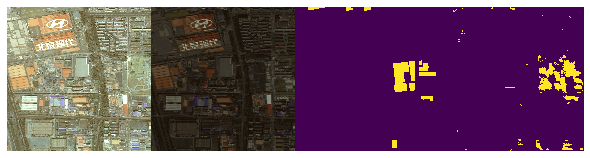

0.8157067666325875


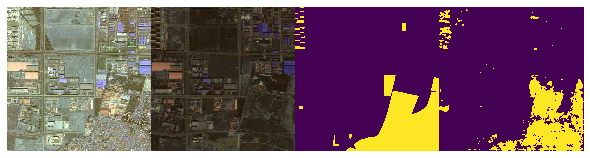

In [18]:
for idx in range(2):
    image1 = TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:,:,[2,1,0]]
    image2 = TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:,:,[2,1,0]]
    # image2 = match_histograms(image2, image1, multichannel=True)
    mask = TIFF.open(image_path_list_mask[idx], mode='r').read_image()
    mask = (mask/255).astype(np.uint8)

    mask_pred = np.zeros((960,960))
    net.eval()
    slide = 256
    size = 512
    # for pos in np.mgrid[0:960:slide,0:960:slide].reshape(2,-1).T:
    x_start, y_start = 0, 0
    size = 960
    x1 = image1[x_start:x_start+size, y_start:y_start+size,:].transpose((2,0,1))
    x2 = image2[x_start:x_start+size, y_start:y_start+size,:].transpose((2,0,1))
    x2 = match_histograms(x2, x1, multichannel=True)
    x1 = torch.from_numpy(x1[np.newaxis,:,:,:].astype(np.float32)).cuda()
    x2 = torch.from_numpy(x2[np.newaxis,:,:,:].astype(np.float32)).cuda()
    with torch.no_grad():
        y = net(x1,x2)


    x1 = x1.cpu().numpy()[0].transpose((1,2,0))
    x2 = x2.cpu().numpy()[0].transpose((1,2,0))
    _, y = torch.max(y, 1)
    y = y.cpu().numpy()[0]
    mask_pred[x_start:x_start+size, y_start:y_start+size] =y

    #     fig, axes = plt.subplots(1,4, figsize=(8,2))
    #     plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)
    #     plt.text(50, 8, str(x_start)+':'+str(y_start), style='italic',fontweight='bold',
    #             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #     axes[0].imshow(normalize(x1))
    #     axes[0].axis('off')
    #     axes[1].imshow(normalize(x2))
    #     axes[1].axis('off')
    #     axes[2].imshow(y)
    #     axes[2].axis('off')
    #     axes[3].imshow(mask[x_start:x_start+size, y_start:y_start+size])
    #     axes[3].axis('off')

    from sklearn.metrics import f1_score
    _, metric = f1_score(mask.reshape(-1,1), mask_pred.reshape(-1,1), average=None)
    print(metric)
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1,4, figsize=(8,2))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    axes[0].imshow(normalize(image1[:,:,[2,1,0]]))
    axes[0].axis('off')
    axes[1].imshow(normalize(image2[:,:,[2,1,0]]))
    axes[1].axis('off')
    axes[2].imshow(mask)
    axes[2].axis('off')
    axes[3].imshow(mask_pred)
    axes[3].axis('off')
    plt.show()

## submit

In [19]:
import os, shutil
save_dir = '/home/yons/workplace/python/change-detection/log/0.3.1/change'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    shutil.rmtree(save_dir)
    os.makedirs(save_dir)

root = '/home/yons/data/rssrai2019_change_detection/test/test'
image_path_list_2018 = glob.glob(root+'/img_2018'+'/*.tif')
image_path_list_2018.sort()
image_path_list_2017 = glob.glob(root+'/img_2017'+'/*.tif')
image_path_list_2017.sort()

for idx in range(len(image_path_list_2017)):
    print(idx)
    mask_pred = np.zeros((960,960))
    image1 = TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:,:,[2,1,0]]
    image2 = TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:,:,[2,1,0]]
    # for pos in np.mgrid[0:960:slide,0:960:slide].reshape(2,-1).T:
    x_start, y_start = 0, 0
    size = 960
        # x_start, y_start = pos
    x1 = image1[x_start:x_start+size, y_start:y_start+size,:].transpose((2,0,1))
    x2 = image2[x_start:x_start+size, y_start:y_start+size,:].transpose((2,0,1))
    x2 = match_histograms(x2, x1, multichannel=True)
    x1 = torch.from_numpy(x1[np.newaxis,:,:,:].astype(np.float32)).cuda()
    x2 = torch.from_numpy(x2[np.newaxis,:,:,:].astype(np.float32)).cuda()
    with torch.no_grad():
        y = net(x1,x2)
    _, y = torch.max(y, 1)
    y = y.cpu().numpy()[0]
    mask_pred[x_start:x_start+size, y_start:y_start+size] =y
    mask_pred = (mask_pred*255).astype(np.uint8)

    # fig, axes = plt.subplots(1,3, figsize=(16,4))
    # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    # axes[0].imshow(normalize(TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:,:,[2,1,0]]))
    # axes[1].imshow(normalize(TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:,:,[2,1,0]]))
    # axes[2].imshow(mask_pred)

    file_name = os.path.basename(image_path_list_2017[idx]).replace('image', 'mask').replace('2017', '2017_2018')
    tif = TIFF.open(os.path.join(save_dir, file_name), mode='w')
    tif.write_image(mask_pred)

import shutil
shutil.make_archive('/home/yons/workplace/python/change-detection/log/0.3.1/change', 'zip', '/home/yons/workplace/python/change-detection/log/0.3.1/change')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


'/home/yons/workplace/python/change-detection/log/0.3.1/change.zip'

### view

In [ ]:
root = '/home/yons/data/rssrai2019_change_detection/test/test'
image_path_list_2018 = glob.glob(root+'/img_2018'+'/*.tif')
image_path_list_2018.sort()
image_path_list_2017 = glob.glob(root+'/img_2017'+'/*.tif')
image_path_list_2017.sort()
save_dir = '/home/yons/workplace/python/change-detection/log/0.3.1/change'
image_path_list_mask = glob.glob(save_dir+'/*.tif')
image_path_list_mask.sort()

# for idx in range(len(image_path_list_2018)):
for idx in range(5):
    image1 = TIFF.open(image_path_list_2017[idx], mode='r').read_image()[:,:,[2,1,0]]
    image2 = TIFF.open(image_path_list_2018[idx], mode='r').read_image()[:,:,[2,1,0]]
    image2 = match_histograms(image2, image1, multichannel=True)
    mask = TIFF.open(image_path_list_mask[idx], mode='r').read_image()
    fig, axes = plt.subplots(1,3, figsize=(8,4))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    axes[0].imshow(normalize(image1))
    axes[1].imshow(normalize(image2))
    axes[2].imshow(mask)
    
